###**EC523 Music Generation**

Working File #1
- Link to dataset
- Code to download the dataset into specific folder (Shared Drive in this case)
- General code base
- Link to midi2wave git
- Preprocessing pipeline for MAESTRO audio and midi


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/Shareddrives/EC523_Project/CodeWorkspace

Mounted at /content/drive
/content/drive/Shareddrives/EC523_Project


In [ ]:
# Midi2Wave Git clone
!git clone https://github.com/plunkgj/midi2wave.git

Cloning into 'midi2wave'...
remote: Enumerating objects: 182, done.
remote: Total 182 (delta 0), reused 0 (delta 0), pack-reused 182
Receiving objects: 100% (182/182), 528.00 KiB | 8.80 MiB/s, done.
Resolving deltas: 100% (117/117), done.


#### downsample and mono-ize maestro audio using librosa.

In [ ]:
import librosa
import csv 
import soundfile as sf

In [ ]:
def resample_audio(dataset, dataset_path, output_path, sample_hz, resample_type):
  
    for i, piece in enumerate(dataset):

        print("file " + str(i), end='\r', flush=True)

        audio, sampling_rate = librosa.load(dataset_path + piece["audio_filename"],
                                            sr=sample_hz,
                                            mono=True,
                                            res_type=resample_type)
        assert(sampling_rate==sample_hz)

        filename = output_path + piece["audio_filename"][5:]
        sf.write(filename, audio, sample_hz)

In [ ]:
metadata = csv.DictReader(open('/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/maestro-v3.0.0.csv'))
test = []
validate = []
train = []
for data in metadata:
    if (data['split']=='train'):
        train.append(data)
    elif (data['split']=='validation'):
        validate.append(data)
    elif (data['split']=='test'):
        test.append(data)
      

In [ ]:
import librosa

dataset_path = '/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/'
output_path = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MAESTRO_DownSample_Mono/test/'
resample_audio(test,dataset_path,output_path, 16000, 'polyphase')


Read MIDI, returns array of notes and chords

In [ ]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

load MIDI into environment (will prob need to modify this part)

In [ ]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path='/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/2004'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".midi")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

print(notes_array)
print(files)


Loading Music File: /content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/2004MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.midi


NameError: ignored

Optional, to understand the dataset

In [ ]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

0


Optional, to understand the dataset

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

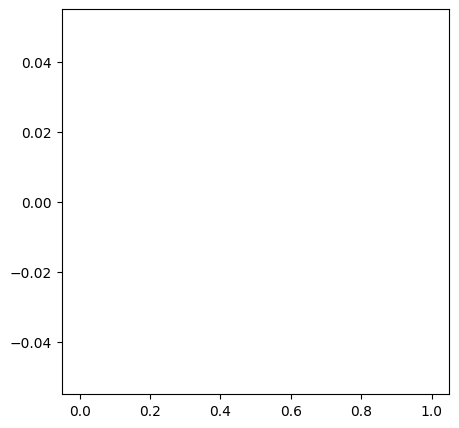

In [ ]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

Prepare new music files only have top frequent notes

In [ ]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

prep input and output

In [ ]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [ ]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

ValueError: ignored

In [ ]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

NameError: ignored

In [ ]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [ ]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Generate your own music

In [ ]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

Convert to MIDI

In [ ]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')